In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [2]:
# Hyper Parameters
EPOCH = 50     
BATCH_SIZE = 100
LR = 0.001            
DOWNLOAD_MNIST = False

In [3]:
from torchvision import transforms, datasets
transform1 = transforms.Compose(
    [
    #transforms.Resize((224,224)),# 大小
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    transforms.Normalize(mean = 0.5, std = (0.5)) # 標準化 (-1,1)
    ]
)

In [4]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='D:\Data\mnist',
    train=True,                                     # this is training data
    transform=transform1,    # Converts a PIL.Image or numpy.ndarray to                            # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
    
)


In [5]:
import random
from random import shuffle
from torch.utils.data.sampler import SubsetRandomSampler
allindex = list(range(6000))
splits = random.sample(allindex, 600 )
[allindex.remove(split) for split in splits]
shuffle(allindex)
shuffle(splits)
tr_sampler = SubsetRandomSampler(allindex)
val_sampler = SubsetRandomSampler(splits)


torch.Size([60000, 28, 28])
torch.Size([60000])


D:\_Python coding\Python evn\practice\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\_Python coding\Python evn\practice\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


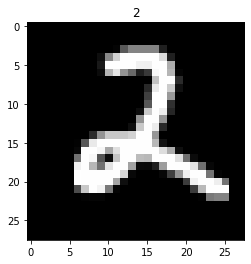

In [6]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
s = random.choice(range(6000))
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.imshow(train_data.train_data[s].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[s])
plt.show()

In [7]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE,sampler=tr_sampler)
valid_loader = Data.DataLoader(dataset=train_data, batch_size= 600,sampler=val_sampler)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        self.conv1 = nn.Sequential( 
            # input shape (1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), 
            # (16,28,28)
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2) 
            # (16,14,14)
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 3, 1, 1),     
            nn.ReLU(),     
            # (32,14,14)
            nn.MaxPool2d(2),   
            # (32,7,7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1 )       
        output = self.out(x)
        return output  

In [9]:
from torchsummary import summary
model = CNN().to('cuda')
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.08
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [10]:
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
loss_func = nn.CrossEntropyLoss()  

In [11]:
from tqdm import tqdm_notebook as tqdm

In [12]:
train_loss =[]
val_loss =[]
train_acc =[]
val_acc =[]
for epoch in range(EPOCH):
    model.train()
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x).to('cuda')  # batch x
        b_y = Variable(y).to('cuda')   # batch y
        
        output = model(b_x)
    
        loss = loss_func(output, b_y)   # cross entropy loss
        pred_y = torch.max(output, 1)[1].data.squeeze()
        accuracy = sum(pred_y == b_y) / b_y.size(0)
        
        
            
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    
        if loss<0.5:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        if step%50==0:
            print("loss:",(loss.item(),"accuracy:",accuracy.item()))
        
        ################################################################################################
    train_loss.append(loss.item())
    train_acc.append(accuracy)
    model.eval()
    for (x, y) in tqdm(valid_loader) :
        b_x = Variable(x).to('cuda') 
        b_y = Variable(y).to('cuda')

        output = model(b_x)
        loss = loss_func(output, b_y)   # cross entropy loss
        pred_y = torch.max(output, 1)[1].data.squeeze()
        accuracy = sum(pred_y == b_y) / b_y.size(0)
        val_loss.append(loss.item())
        val_acc.append(accuracy.item())
           
    print('done') 

loss: (2.3119957447052, 'accuracy:', 0.05999999865889549)
loss: (2.2410085201263428, 'accuracy:', 0.4399999976158142)


C:\Users\user\AppData\Local\Temp/ipykernel_1172/535793059.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (x, y) in tqdm(valid_loader) :


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (2.2135660648345947, 'accuracy:', 0.5899999737739563)
loss: (2.0954129695892334, 'accuracy:', 0.699999988079071)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (2.028864860534668, 'accuracy:', 0.7799999713897705)
loss: (1.7424063682556152, 'accuracy:', 0.7799999713897705)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (1.724432349205017, 'accuracy:', 0.7699999809265137)
loss: (1.1761528253555298, 'accuracy:', 0.7799999713897705)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (1.0672333240509033, 'accuracy:', 0.8499999642372131)
loss: (0.7569596171379089, 'accuracy:', 0.85999995470047)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.6059602499008179, 'accuracy:', 0.8899999856948853)
loss: (0.5841166973114014, 'accuracy:', 0.8399999737739563)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.5754565596580505, 'accuracy:', 0.85999995470047)
loss: (0.5176284313201904, 'accuracy:', 0.8299999833106995)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.4096965789794922, 'accuracy:', 0.8899999856948853)
loss: (0.3843483030796051, 'accuracy:', 0.8499999642372131)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.449088454246521, 'accuracy:', 0.85999995470047)
loss: (0.39320486783981323, 'accuracy:', 0.9099999666213989)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.6582478284835815, 'accuracy:', 0.85999995470047)
loss: (0.30834129452705383, 'accuracy:', 0.9300000071525574)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.2990065813064575, 'accuracy:', 0.9199999570846558)
loss: (0.24653849005699158, 'accuracy:', 0.9300000071525574)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.3229685127735138, 'accuracy:', 0.8999999761581421)
loss: (0.27843648195266724, 'accuracy:', 0.9300000071525574)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.3050993084907532, 'accuracy:', 0.9300000071525574)
loss: (0.3298887312412262, 'accuracy:', 0.9099999666213989)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.297267347574234, 'accuracy:', 0.8999999761581421)
loss: (0.244592547416687, 'accuracy:', 0.949999988079071)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.3880045711994171, 'accuracy:', 0.9300000071525574)
loss: (0.25563403964042664, 'accuracy:', 0.8999999761581421)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.2409963756799698, 'accuracy:', 0.949999988079071)
loss: (0.17823369801044464, 'accuracy:', 0.9599999785423279)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.21395941078662872, 'accuracy:', 0.9399999976158142)
loss: (0.26916512846946716, 'accuracy:', 0.9099999666213989)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.22535520792007446, 'accuracy:', 0.9199999570846558)
loss: (0.18000349402427673, 'accuracy:', 0.949999988079071)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.38764724135398865, 'accuracy:', 0.9099999666213989)
loss: (0.13094137609004974, 'accuracy:', 0.9399999976158142)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.27683913707733154, 'accuracy:', 0.9300000071525574)
loss: (0.1975289285182953, 'accuracy:', 0.9199999570846558)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.3072175085544586, 'accuracy:', 0.9300000071525574)
loss: (0.27661770582199097, 'accuracy:', 0.9399999976158142)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.1493515521287918, 'accuracy:', 0.949999988079071)
loss: (0.24675936996936798, 'accuracy:', 0.9399999976158142)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.24930782616138458, 'accuracy:', 0.949999988079071)
loss: (0.253902405500412, 'accuracy:', 0.949999988079071)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.24026742577552795, 'accuracy:', 0.9199999570846558)
loss: (0.25138506293296814, 'accuracy:', 0.9300000071525574)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.14116902649402618, 'accuracy:', 0.9699999690055847)
loss: (0.23619800806045532, 'accuracy:', 0.949999988079071)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.09091737866401672, 'accuracy:', 0.9899999499320984)
loss: (0.11681664735078812, 'accuracy:', 0.9599999785423279)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.1524398922920227, 'accuracy:', 0.949999988079071)
loss: (0.16287370026111603, 'accuracy:', 0.9599999785423279)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.0973212793469429, 'accuracy:', 0.9799999594688416)
loss: (0.17984914779663086, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.09972769767045975, 'accuracy:', 0.9699999690055847)
loss: (0.12632165849208832, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.18757957220077515, 'accuracy:', 0.9599999785423279)
loss: (0.20690765976905823, 'accuracy:', 0.9199999570846558)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.15994784235954285, 'accuracy:', 0.9300000071525574)
loss: (0.30065035820007324, 'accuracy:', 0.9300000071525574)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.09553063660860062, 'accuracy:', 0.9599999785423279)
loss: (0.21152448654174805, 'accuracy:', 0.949999988079071)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.13328087329864502, 'accuracy:', 0.9599999785423279)
loss: (0.09754524379968643, 'accuracy:', 0.9799999594688416)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.18347713351249695, 'accuracy:', 0.9799999594688416)
loss: (0.09096064418554306, 'accuracy:', 0.9799999594688416)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.15193301439285278, 'accuracy:', 0.9599999785423279)
loss: (0.07633257657289505, 'accuracy:', 0.9799999594688416)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.10520125180482864, 'accuracy:', 0.9699999690055847)
loss: (0.13810303807258606, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.19441339373588562, 'accuracy:', 0.9300000071525574)
loss: (0.1438368409872055, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.24141623079776764, 'accuracy:', 0.9399999976158142)
loss: (0.08713435381650925, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.07474841177463531, 'accuracy:', 0.9699999690055847)
loss: (0.16167756915092468, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.08224883675575256, 'accuracy:', 0.9799999594688416)
loss: (0.11714759469032288, 'accuracy:', 0.9599999785423279)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.11546015739440918, 'accuracy:', 0.9699999690055847)
loss: (0.30860355496406555, 'accuracy:', 0.9399999976158142)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.21533827483654022, 'accuracy:', 0.949999988079071)
loss: (0.11442917585372925, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.2556121349334717, 'accuracy:', 0.9399999976158142)
loss: (0.12074021250009537, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.09778578579425812, 'accuracy:', 0.9799999594688416)
loss: (0.1638374775648117, 'accuracy:', 0.9399999976158142)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.151297464966774, 'accuracy:', 0.9699999690055847)
loss: (0.11342980712652206, 'accuracy:', 0.949999988079071)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.09365382790565491, 'accuracy:', 0.9799999594688416)
loss: (0.11729319393634796, 'accuracy:', 0.9699999690055847)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.03519807755947113, 'accuracy:', 0.9899999499320984)
loss: (0.12042465060949326, 'accuracy:', 0.9799999594688416)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.14654089510440826, 'accuracy:', 0.9599999785423279)
loss: (0.17923098802566528, 'accuracy:', 0.9399999976158142)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.06900720298290253, 'accuracy:', 0.9899999499320984)
loss: (0.15918204188346863, 'accuracy:', 0.9599999785423279)


  0%|          | 0/1 [00:00<?, ?it/s]

done
loss: (0.13832694292068481, 'accuracy:', 0.949999988079071)
loss: (0.14150835573673248, 'accuracy:', 0.9599999785423279)


  0%|          | 0/1 [00:00<?, ?it/s]

done


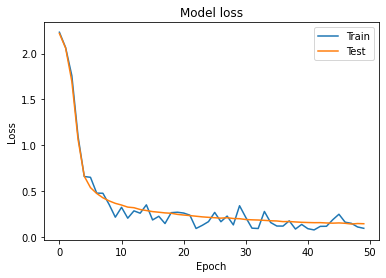

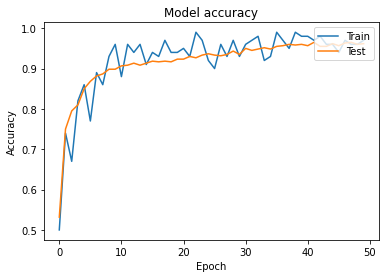

In [15]:
# 損失函數

fig = plt.figure()
# set_facecolor用于設定背景顏色
fig.patch.set_facecolor('white')
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


fig = plt.figure()
# set_facecolor用于設定背景顏色
fig.patch.set_facecolor('white')
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()